## VGG Labeler to Coco

In [1]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd

In [2]:
## Dataset Parameters ##
WORKING_DIRECTORY = '/media/dean/datastore/ROAD_COCO'

COCO_DIRECTORY = '/media/dean/datastore/ROAD_COCO/darknet/data/coco/'
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY,'images/road_coco_train2014/')
images_path = "{}{}".format( IMAGES_DIRECTORY, '*.jpg')

COCO_ANNOTATIONS = '/media/dean/datastore/ROAD_COCO/darknet/data/coco/annotations/roadcoco_instances_train2014.json'

## VGG Labeler Dataset Extraction Parameters ##
VGG_ANNS_CSV = os.path.join(WORKING_DIRECTORY, 'night_detections.csv')
HEADER_ROW=['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']

### Helper Functions - Kache Dataset Loading

In [3]:
def maybe_download(source_url, filename):
    if not os.path.exists(IMAGES_DIRECTORY):
        os.mkdir(IMAGES_DIRECTORY)
    
    filepath = os.path.join(IMAGES_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [4]:
## Extract Labels ##
annotations = pd.read_csv(VGG_ANNS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,0,"{""name"":""rect"",""x"":608.801887512207,""y"":215.52...","{""type"":""car""}"
1,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,1,"{""name"":""rect"",""x"":68.84820938110352,""y"":231.7...","{""type"":"" car""}"
2,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,2,"{""name"":""rect"",""x"":800,""y"":202,""width"":19,""hei...","{""type"":""person""}"
3,http://ec2-18-236-156-72.us-west-2.compute.ama...,25037,{},3,0,"{""name"":""rect"",""x"":438.3702850341797,""y"":219.0...","{""type"":""car""}"
4,http://ec2-18-236-156-72.us-west-2.compute.ama...,25037,{},3,1,"{""name"":""rect"",""x"":328.9356918334961,""y"":226.0...","{""type"":"" car""}"


## Download Images into Training Directory

In [5]:
urlstofilepaths = {}
url_paths = set(annotations['filename'].tolist())

for url in url_paths:
    fname = os.path.split(url)[-1]
    urlstofilepaths[url] = maybe_download(url, os.path.join(IMAGES_DIRECTORY, fname))
print(urlstofilepaths)

{'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night39.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/night39.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night221.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/night221.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night374.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/night374.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night245.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/night245.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night435.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/night435.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/test

In [6]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import pylab

images_directory = IMAGES_DIRECTORY
fixed_coco = COCO('/media/dean/datastore/ROAD_COCO/darknet/data/coco/annotations/instances_train2014.json')

categories = fixed_coco.loadCats(fixed_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...


/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/dean/miniconda3/envs/ros-kache/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dean/miniconda3/envs/ros-kache/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dean/miniconda3/envs/r

Done (t=9.01s)
creating index...
index created!
Custom COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [7]:
# Script to convert VGG Labeler Annotations to Coco Json Annotations
import xml.etree.cElementTree as ET
import glob
import argparse
import os
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import ast

from PIL import Image


# annotations initialized above #

images, anns = [], []
    
img_offset = 3000001

num_imgs = len(url_paths)
ann_index = 3000000
    
for img_id, url in enumerate(sorted(set(url_paths))):
    im = Image.open(urlstofilepaths[url])
    width, height = im.size
    dic = {'file_name': os.path.split(url)[-1], 'id': img_offset+img_id, 'height': height, 'width': width}
    images.append(dic)
    
    for annotation in [x for x in annotations.as_matrix() if x[0].lower() == url.lower()]:

        
        # xy coords: [xstart, ystart, xstop, ystop] -> bbox = [x,y,width,height]
        
        d = ast.literal_eval(annotation[5])
        
        if d:
            if float(d['x']) < 0:
                d['x'] = 0.0
            if float(d['y']) < 0:
                d['y'] = 0.0
            if float(d['height']) <= 0:
                d['height'] = 1.0
                
            if float(d['width']) <= 0:
                d['width'] = 1.0   
            
                
            # Get Points
            pts = []
            pts.append(((float(d['x']) , float(d['y']))))
            pts.append((float(d['x'])+float(d['width']) , float(d['y'])))
            pts.append((float(d['x'])+float(d['width']) , float(d['y'])+float(d['height'])))
            pts.append((float(d['x']) , float(d['y'])+float(d['height'])))


            # Convert XML Polygon pts to Coco-friendly bounding boxes
            points = MultiPoint(pts)
            xstart,ystart,xstop,ystop = points.bounds

            # Cast to Integers
            xstart,ystart,xstop,ystop = int(xstart),int(ystart),int(xstop),int(ystop)

            binary_mask = np.zeros_like(im)[:,:,0]
            binary_mask[int(xstart):int(xstop), int(ystart):int(ystop)] +=1


            contours = measure.find_contours(binary_mask, 0.5, positive_orientation='low')
            polygons = []
            segmentations = []

            
            
            
            for contour in contours:
                poly = Polygon(contour)
                poly = poly.simplify(1.0, preserve_topology=False)

                if poly and poly.exterior:
                    polygons.append(poly)
                    segmentation = np.array(poly.exterior.coords).ravel().tolist()
                    segmentations.append(segmentation)

            # Combine the polygons to calculate the bounding box and area
            multi_poly = MultiPolygon(polygons)
            if multi_poly.bounds:
                x, y, max_x, max_y = multi_poly.bounds
                width = max_x - x
                height = max_y - y
                bbox = (x, y, width, height)
                area = multi_poly.area



                # Get Label
                cls = ast.literal_eval(annotation[6])
                cat = cls['type'].lower().strip()
                
                if cat == 'motorbike':
                    category_id = fixed_coco.getCatIds(catNms=['motorcycle'])
                else:
                    category_id = fixed_coco.getCatIds(catNms=[cat])
                    
                    
                if not category_id: #Hardcode tv for now
                    category_id = fixed_coco.getCatIds(catNms=['tv'])
                
                if type(category_id) == list:
                    category_id = category_id[0]
                
                #print('Category:',cat,'| Category ID:', category_id)

                annotation = {
                    'segmentation': segmentations,
                    'iscrowd': 0,
                    'image_id': img_offset+img_id, # Don't want to conflict with existing dataset
                    'category_id': category_id,
                    'id': ann_index,
                    'bbox': bbox,
                    'area': area
                }
                ann_index+=1
                anns.append(annotation)

/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [8]:
print(anns[:10])

[{'segmentation': [[719.0, 214.5, 608.0, 214.5, 607.5, 322.0, 719.0, 322.5, 719.0, 214.5]], 'iscrowd': 0, 'image_id': 3000001, 'category_id': 3, 'id': 3000000, 'bbox': (607.5, 214.5, 111.5, 108.0), 'area': 11987.25}, {'segmentation': [[152.5, 266.0, 152.0, 230.5, 67.5, 231.0, 68.0, 266.5, 152.5, 266.0]], 'iscrowd': 0, 'image_id': 3000001, 'category_id': 3, 'id': 3000001, 'bbox': (67.5, 230.5, 85.0, 36.0), 'area': 3000.0}, {'segmentation': [[512.5, 276.0, 512.0, 218.5, 437.5, 219.0, 438.0, 276.5, 512.5, 276.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 3000002, 'bbox': (437.5, 218.5, 75.0, 58.0), 'area': 4284.0}, {'segmentation': [[398.5, 272.0, 398.0, 225.5, 327.5, 226.0, 328.0, 272.5, 398.5, 272.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 3000003, 'bbox': (327.5, 225.5, 71.0, 47.0), 'area': 3278.5}, {'segmentation': [[438.5, 256.0, 438.5, 227.0, 418.0, 226.5, 417.5, 256.0, 438.5, 256.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 

In [9]:
from datetime import datetime
INFO = {
    "description": "Road Object-Detections Dataset based on MS COCO",
    "url": "https://kache.ai",
    "version": "0.0.1",
    "year": 2018,
    "contributor": "deanwebb",
    "date_created": datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "The MIT License (MIT)",
        "url": "https://opensource.org/licenses/MIT",
        "description":  """
                        The MIT License (MIT)
                        Copyright (c) 2017 Matterport, Inc.

                        Permission is hereby granted, free of charge, to any person obtaining a copy
                        of this software and associated documentation files (the "Software"), to deal
                        in the Software without restriction, including without limitation the rights
                        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
                        copies of the Software, and to permit persons to whom the Software is
                        furnished to do so, subject to the following conditions:

                        The above copyright notice and this permission notice shall be included in
                        all copies or substantial portions of the Software.

                        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
                        IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
                        FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
                        AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
                        LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
                        OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
                        THE SOFTWARE.
                        """
    }
]

coco_output = {'info': INFO, 'licenses': LICENSES, 'images':images, 'annotations':anns, 'categories': categories}
with open('{}/roadcoco_instances_train2014.json'.format('/media/dean/datastore/ROAD_COCO/darknet/data/coco/annotations/'), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [10]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [11]:
image_directory = IMAGES_DIRECTORY


In [12]:
example_coco = COCO(COCO_ANNOTATIONS)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

supercategory_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(supercategory_names)))

Custom COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

Custom COCO supercategories: 
food kitchen appliance indoor person outdoor animal furniture electronic vehicle sports accessory


In [19]:
category_ids = example_coco.getCatIds(catNms=list(category_names))
image_ids = example_coco.getImgIds()
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
print(image_data)

{'file_name': 'night220.jpg', 'id': 3000116, 'height': 720, 'width': 1280}


[3000378, 3000379, 3000380]
[{'segmentation': [[674.5, 276.0, 674.0, 220.5, 592.5, 221.0, 593.0, 276.5, 674.5, 276.0]], 'iscrowd': 0, 'image_id': 3000116, 'category_id': 3, 'id': 3000378, 'bbox': [592.5, 220.5, 82.0, 56.0], 'area': 4523.5}, {'segmentation': [[553.5, 327.0, 553.0, 219.5, 415.5, 220.0, 416.0, 327.5, 553.5, 327.0]], 'iscrowd': 0, 'image_id': 3000116, 'category_id': 3, 'id': 3000379, 'bbox': [415.5, 219.5, 138.0, 108.0], 'area': 14781.5}, {'segmentation': [[597.5, 259.0, 597.0, 225.5, 558.5, 226.0, 559.0, 259.5, 597.5, 259.0]], 'iscrowd': 0, 'image_id': 3000116, 'category_id': 3, 'id': 3000380, 'bbox': [558.5, 225.5, 39.0, 34.0], 'area': 1290.0}]


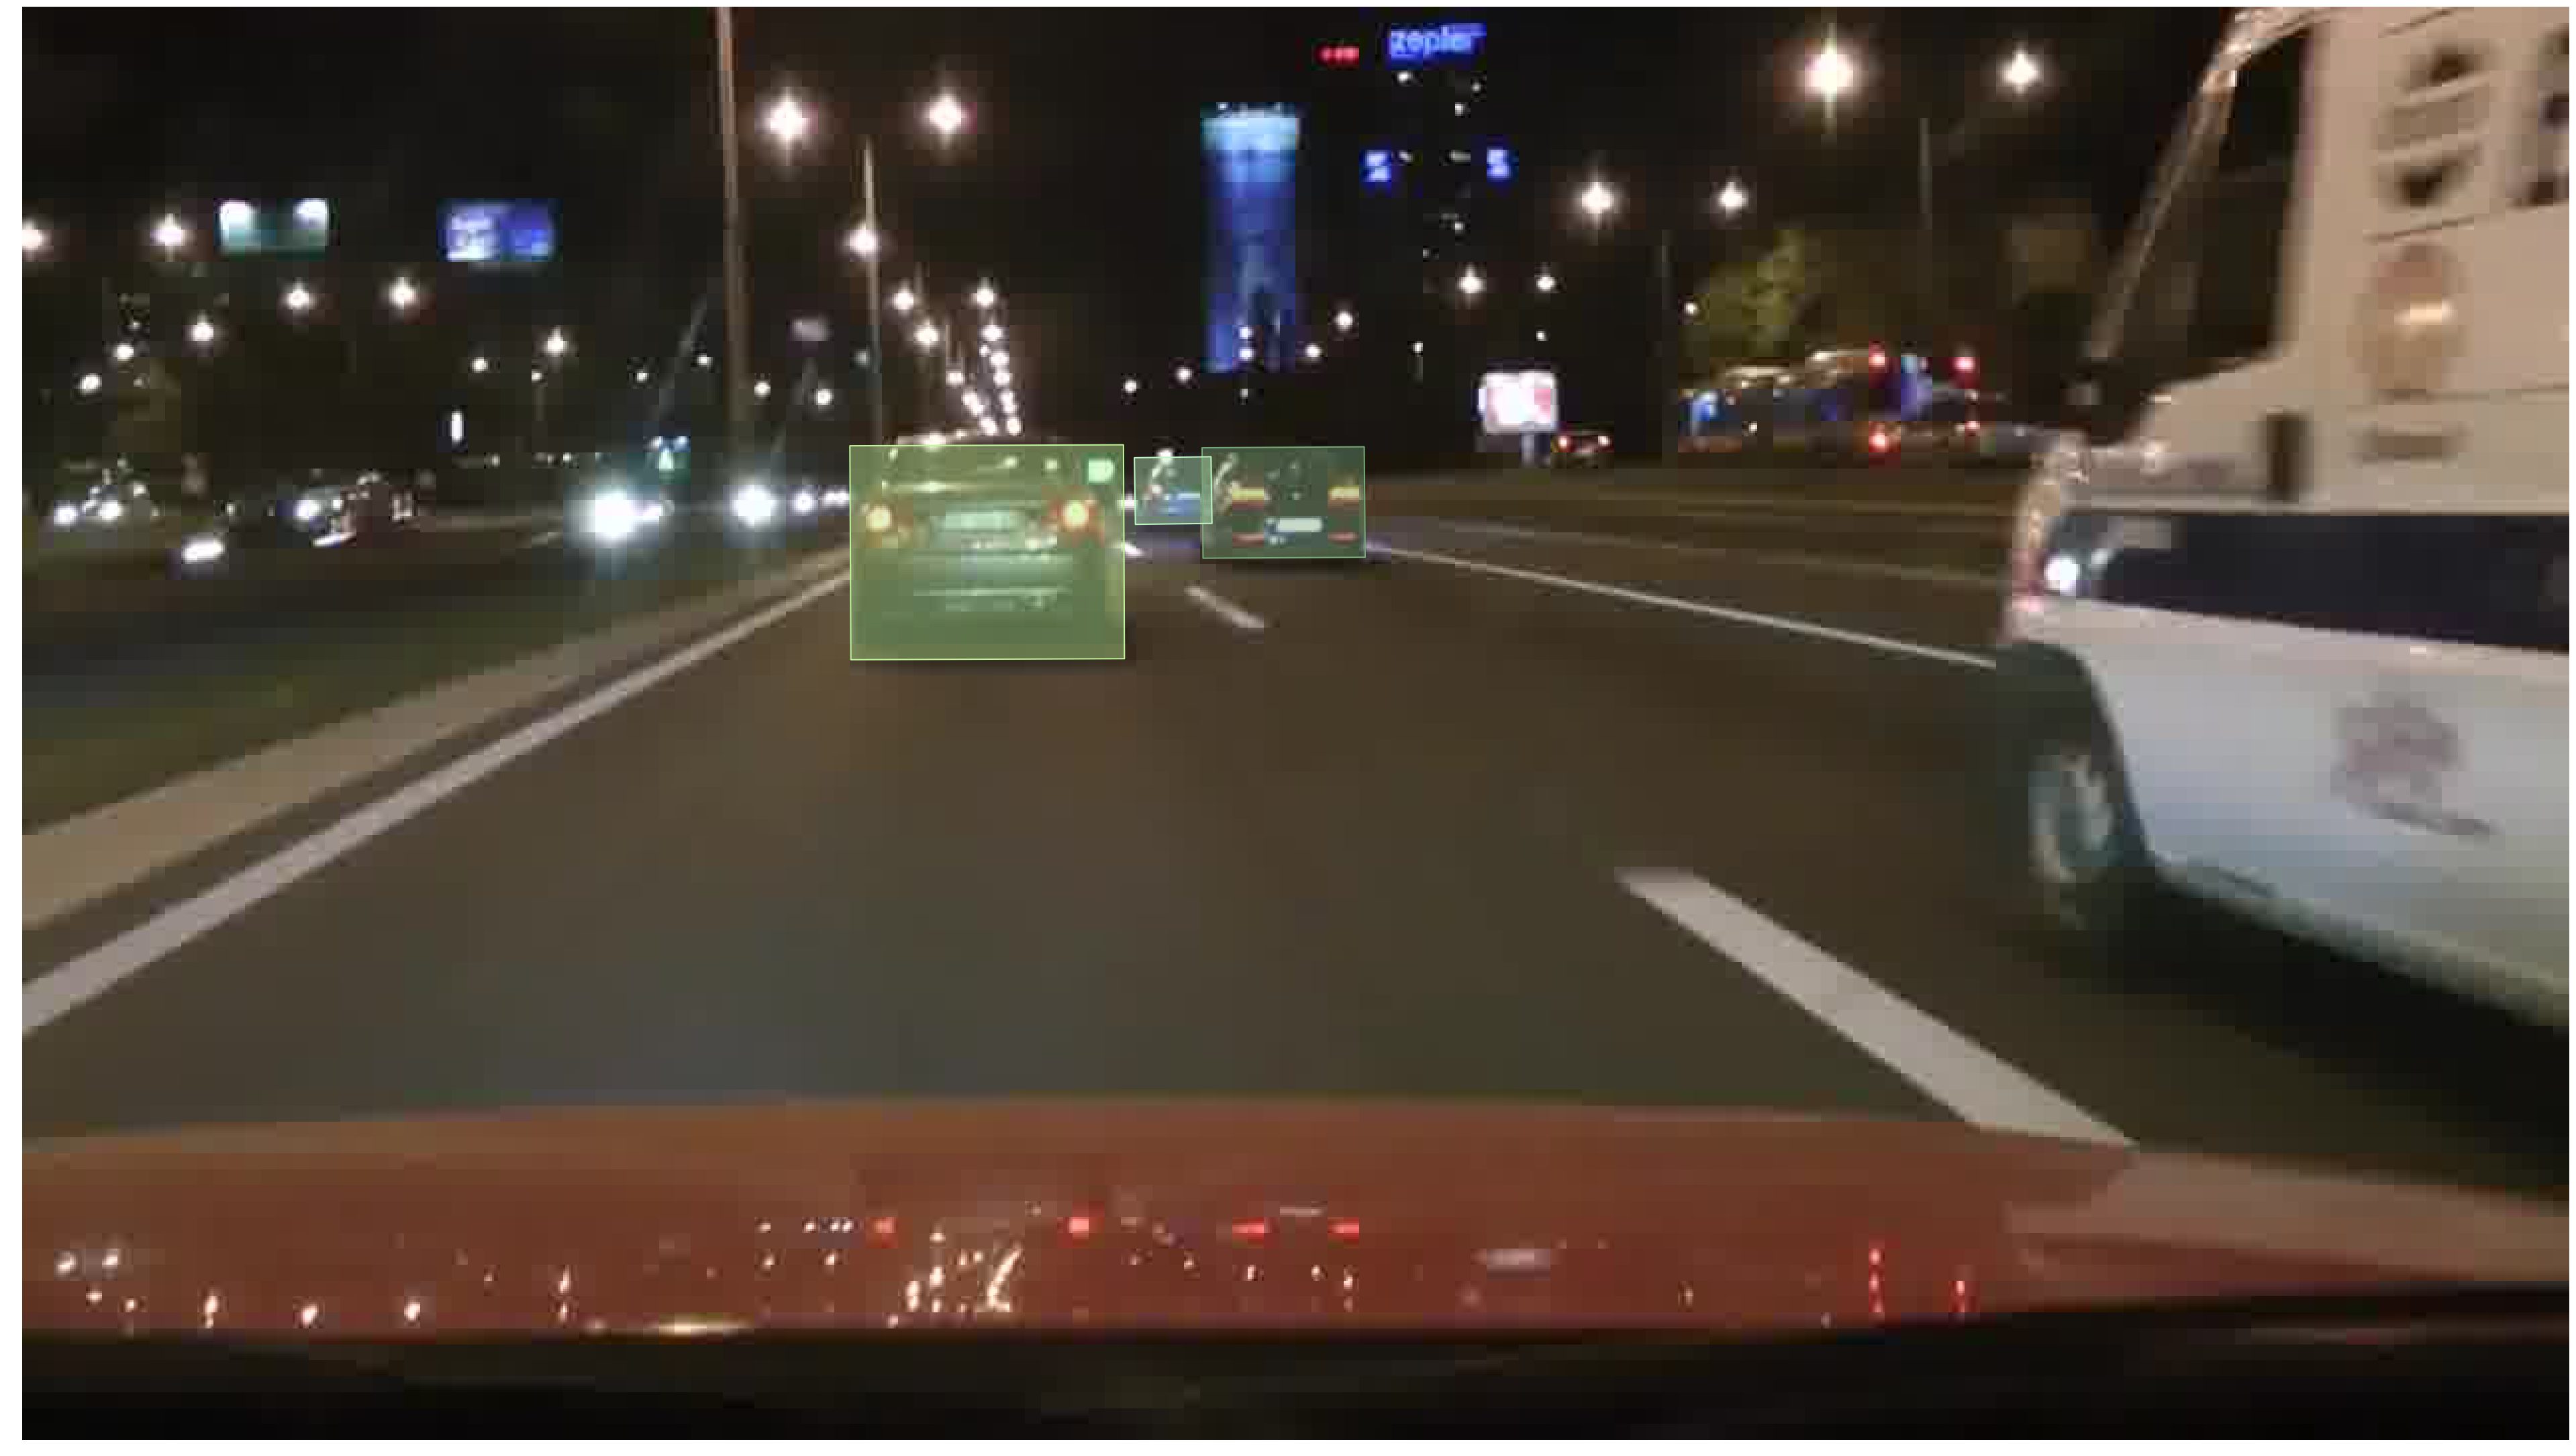

In [21]:
# load and display instance annotations
image = io.imread(os.path.join(image_directory ,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (68.0, 120.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
print(annotation_ids)


annotations = example_coco.loadAnns(annotation_ids)
print(annotations)
example_coco.showAnns(annotations)

In [16]:
!java -jar /media/dean/datastore/ROAD_COCO/darknet/data/cocotoyolo.jar "/media/dean/datastore/ROAD_COCO/darknet/data/coco/annotations/roadcoco_instances_train2014.json" "/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/road_coco_train2014/" "all" "/media/dean/datastore/ROAD_COCO/darknet/data/coco/labels/road_coco_train2014"

Loading annotations...
RootEntry{info=InfoEntry{year=2018, version='0.0.1', description='Road Object-Detections Dataset based on MS COCO', contributor='deanwebb', url='https://kache.ai', dateCreated='2018-08-28 02:17:24.496891'}, # images=370, # annotations=1383, # licenses=1, # categories=80}
